# ENERGY BASED MODELS 

we know that boltzman distribution, p(x) = e^(-E(x)) / integral(e^(-E(x) dx)   
here, we use deep Neural networks for calculating E(x), for true samples, the value is small and for fake samples it is less.
since calculating integral in p(x), we can't use the maximum likelihood, instead we can use contrastive divergence as a loss function which was proposed by hinton in 2002. (proposed for product of experts (PoEs))  
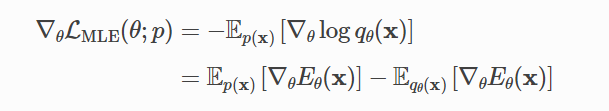
similarly, for sampling data, we use Lagevin dynamics. here, we take random sample and calculate the E(x), and updates the
 input x such that gradient of E(x) reduced in that direction. (same like backprop used for weights update, but here gradient E(x) with x)
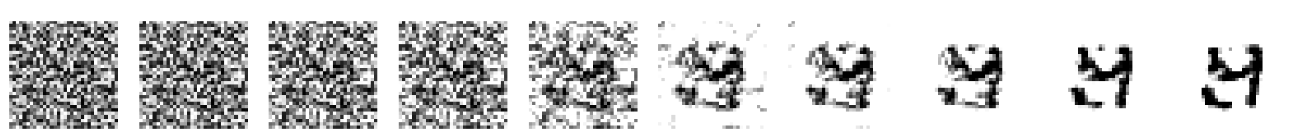

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)

import matplotlib.pyplot as plt
import random

In [3]:
# functions for sample batch and displaying them
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


## Data Preprocessing 

In [4]:
# parameters
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = False

In [5]:
# Load the data
(x_train, _), (x_test, _) = datasets.mnist.load_data()

In [6]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [7]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

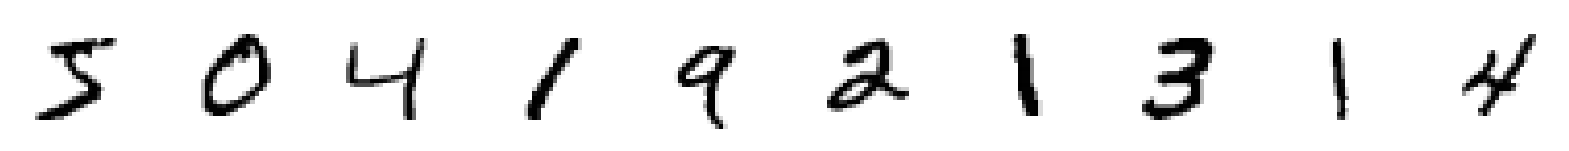

In [8]:
# Show some items of clothing from the training set
train_sample = sample_batch(x_train)
display(train_sample)

# EBM network

In [9]:
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448 

In [10]:
if LOAD_MODEL:
    model.load_weights("model.h5")

# Langevian Sampling

In [12]:
# function to generate samples using Langevian dynamics

def generate_samples(model,inp_imgs,steps,step_size,noise, return_img_per_step  =False):
    
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean = 0, stddev = noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs) #bydefault it watches trainable parameters
            out_score = model(inp_imgs)
        
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        
        inp_imgs += step_size*grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs
        

# contrastive divergence  
for this, we take training samples as real images, and for fake ones, we take samples from distribution itself, so by this way, hinton showed that this contrastive divergence tends to maximum likelihood estimation at long run, lets create a class for storing buffer images for every iteration of update in weights of model.

In [13]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2
            - 1
            for _ in range(BATCH_SIZE)
        ]
    
    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = (tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))*2 - 1)
        old_imgs = tf.concat(random.choices(self.examples, k = BATCH_SIZE-n_new),axis = 0)
        
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis = 0)
        inp_imgs = generate_samples(self.model, inp_imgs, steps = steps,
                                   step_size = step_size, noise = noise)
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis = 0)+ self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        
        return inp_imgs
        

# EBM CUSTOM CLASS

In [15]:
class EBM(models.Model):
    def __init__(self):
        super(EBM,self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name = "loss")
        self.reg_loss_metric = metrics.Mean(name = "reg")
        self.cdiv_loss_metric = metrics.Mean(name = "cdiv")
        self.real_out_metric = metrics.Mean(name = "real")
        self.fake_out_metric = metrics.Mean(name = "fake")
        
    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]
    
    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=NOISE
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs),2,axis = 0)
            cdiv_loss = tf.reduce_mean(fake_out,axis = 0) - tf.reduce_mean(real_out, axis = 0)
            reg_loss = self.alpha * tf.reduce_mean(  real_out**2 + fake_out**2, axis=0 )
            loss = cdiv_loss + reg_loss
            
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))* 2- 1)
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(real_out, axis=0)
        
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        
        return {m.name: m.result() for m in self.metrics[2:]}
        

In [16]:
ebm = EBM()

# Training the EBM Network

In [17]:
# Compile and train the model
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

In [18]:
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (np.random.uniform(size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))* 2- 1)
        
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=STEP_SIZE,
  
            noise=NOISE,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(generated_images)

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(example_images)


image_generator_callback = ImageGenerator(num_img=10)

In [22]:
class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights("model.h5")


save_model_callback = SaveModel()

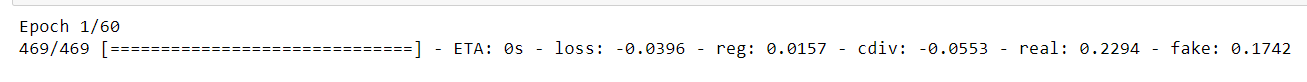

Epoch 1/12
469/469 [==============================] - ETA: 0s - loss: -0.0038 - reg: 0.0024 - cdiv: -0.0062 - real: 0.0145 - fake: 0.0083

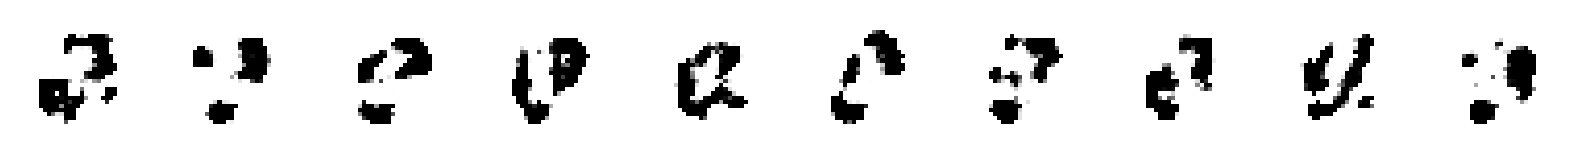

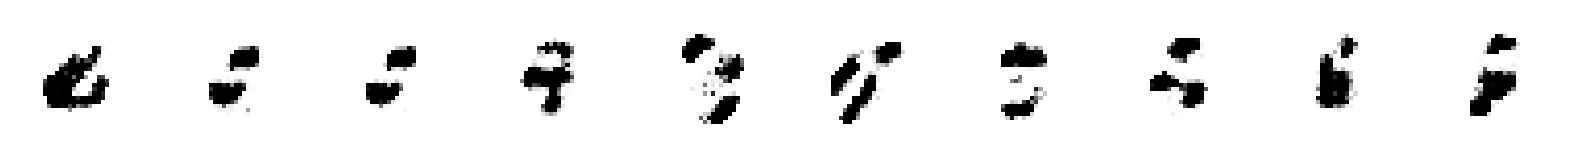

469/469 [==============================] - 1760s 4s/step - loss: -0.0038 - reg: 0.0024 - cdiv: -0.0062 - real: 0.0145 - fake: 0.0083 - val_cdiv: -1.8036 - val_real: -0.0942 - val_fake: -1.8979
Epoch 2/12
469/469 [==============================] - ETA: 0s - loss: -0.0013 - reg: 0.0012 - cdiv: -0.0024 - real: 0.0050 - fake: 0.0026

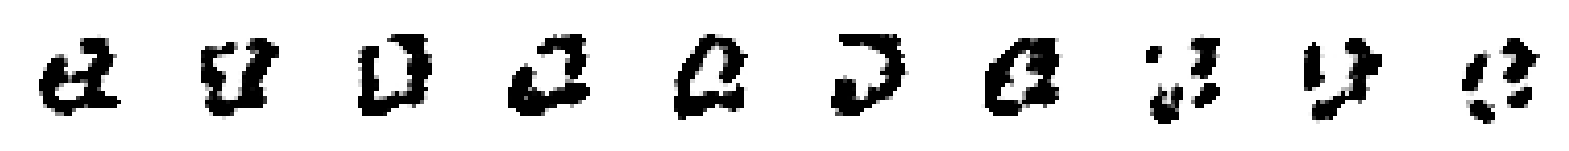

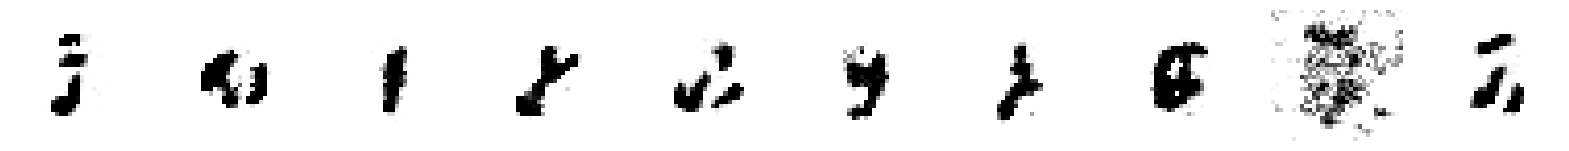

469/469 [==============================] - 1766s 4s/step - loss: -0.0013 - reg: 0.0012 - cdiv: -0.0024 - real: 0.0050 - fake: 0.0026 - val_cdiv: -2.2198 - val_real: -0.0377 - val_fake: -2.2575
Epoch 3/12
469/469 [==============================] - ETA: 0s - loss: 2.8115e-04 - reg: 5.2377e-04 - cdiv: -2.4262e-04 - real: 0.0027 - fake: 0.0024

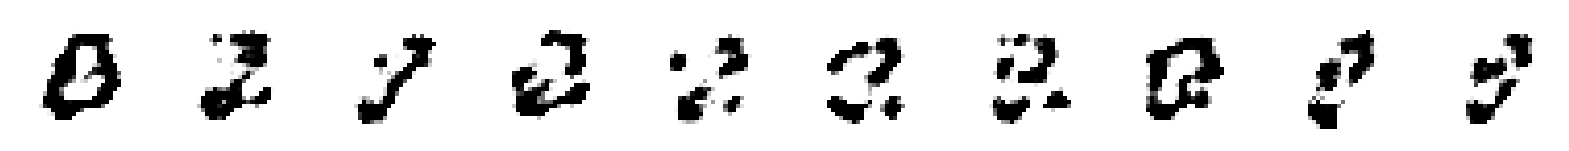

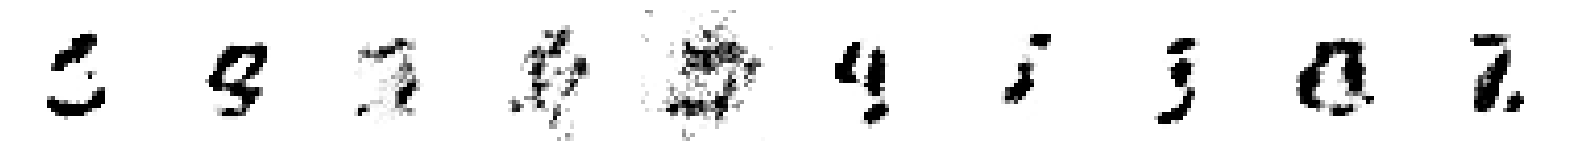

469/469 [==============================] - 1816s 4s/step - loss: 2.8115e-04 - reg: 5.2377e-04 - cdiv: -2.4262e-04 - real: 0.0027 - fake: 0.0024 - val_cdiv: -2.4969 - val_real: -0.0362 - val_fake: -2.5331
Epoch 4/12
469/469 [==============================] - ETA: 0s - loss: 7.1939e-05 - reg: 3.2047e-04 - cdiv: -2.4853e-04 - real: 0.0023 - fake: 0.0021

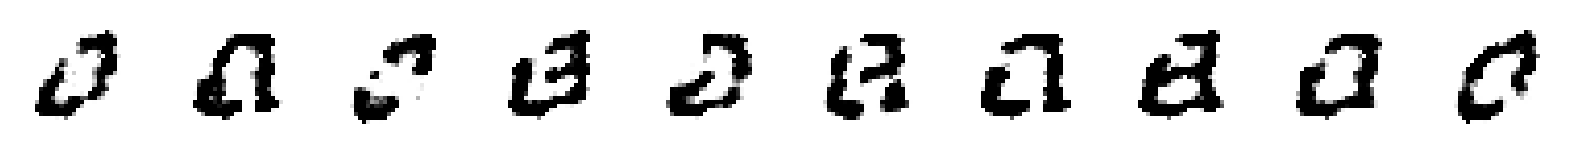

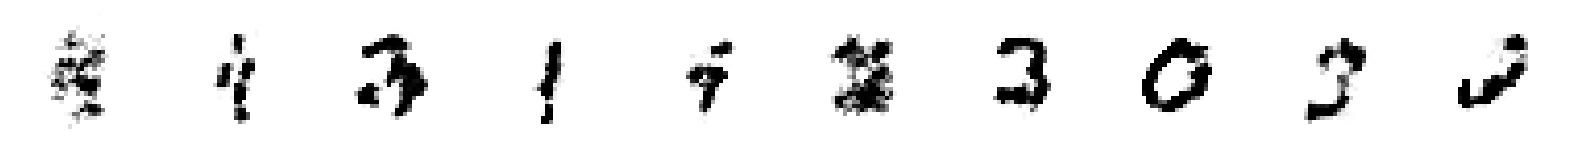

469/469 [==============================] - 1757s 4s/step - loss: 7.1939e-05 - reg: 3.2047e-04 - cdiv: -2.4853e-04 - real: 0.0023 - fake: 0.0021 - val_cdiv: -2.9156 - val_real: -0.0520 - val_fake: -2.9677
Epoch 5/12
469/469 [==============================] - ETA: 0s - loss: 8.6799e-04 - reg: 2.3078e-04 - cdiv: 6.3721e-04 - real: 0.0011 - fake: 0.0018

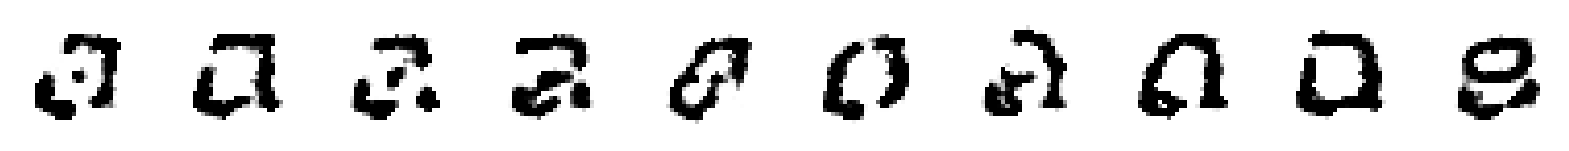

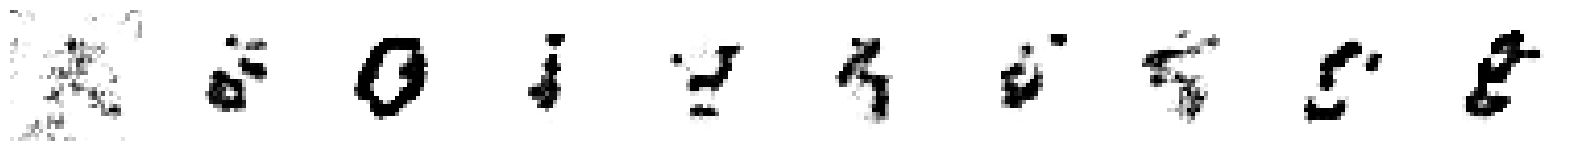

469/469 [==============================] - 1530s 3s/step - loss: 8.6799e-04 - reg: 2.3078e-04 - cdiv: 6.3721e-04 - real: 0.0011 - fake: 0.0018 - val_cdiv: -3.1362 - val_real: -0.0371 - val_fake: -3.1733
Epoch 6/12
469/469 [==============================] - ETA: 0s - loss: 2.5229e-04 - reg: 2.4733e-04 - cdiv: 4.9676e-06 - real: 0.0017 - fake: 0.0017

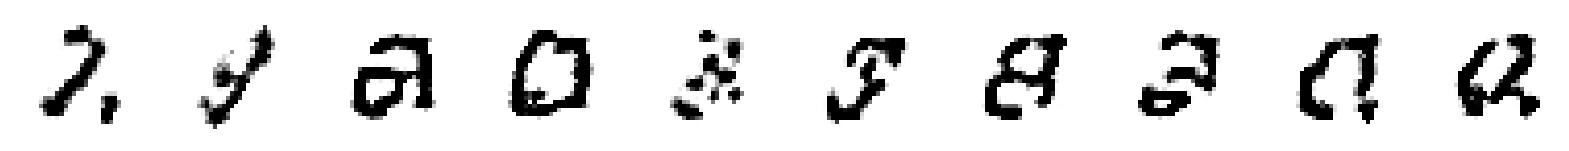

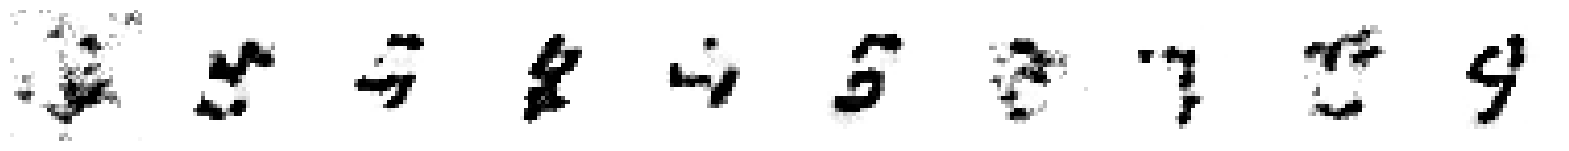

469/469 [==============================] - 1711s 4s/step - loss: 2.5229e-04 - reg: 2.4733e-04 - cdiv: 4.9676e-06 - real: 0.0017 - fake: 0.0017 - val_cdiv: -3.5298 - val_real: -0.0333 - val_fake: -3.5630
Epoch 7/12
469/469 [==============================] - ETA: 0s - loss: 3.2825e-04 - reg: 2.3483e-04 - cdiv: 9.3419e-05 - real: 0.0017 - fake: 0.0018

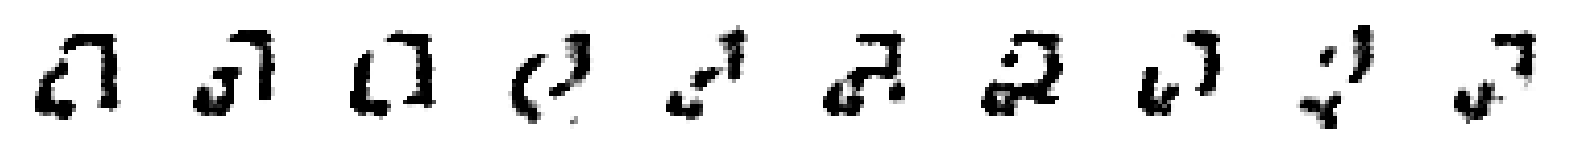

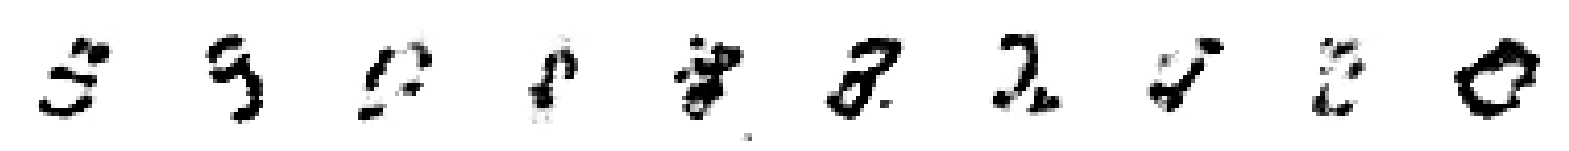

469/469 [==============================] - 1746s 4s/step - loss: 3.2825e-04 - reg: 2.3483e-04 - cdiv: 9.3419e-05 - real: 0.0017 - fake: 0.0018 - val_cdiv: -3.9674 - val_real: -0.0105 - val_fake: -3.9780
Epoch 8/12
469/469 [==============================] - ETA: 0s - loss: 2.9877e-04 - reg: 2.3870e-04 - cdiv: 6.0070e-05 - real: 0.0010 - fake: 0.0011  

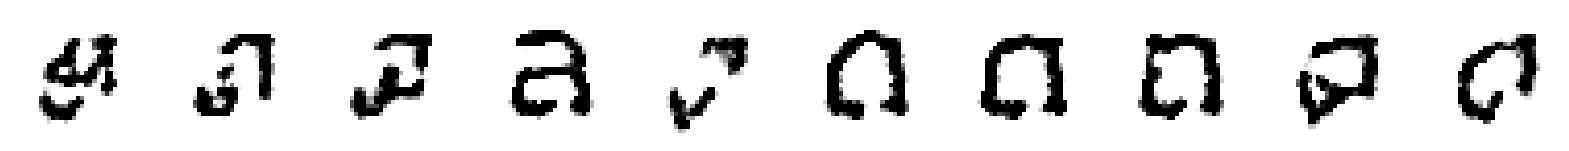

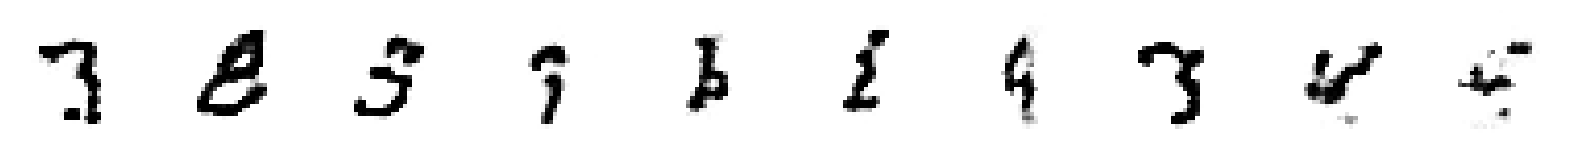

469/469 [==============================] - 1737s 4s/step - loss: 2.9877e-04 - reg: 2.3870e-04 - cdiv: 6.0070e-05 - real: 0.0010 - fake: 0.0011 - val_cdiv: -4.2603 - val_real: 0.0017 - val_fake: -4.2586
Epoch 9/12
469/469 [==============================] - ETA: 0s - loss: 4.5997e-04 - reg: 2.5545e-04 - cdiv: 2.0452e-04 - real: 0.0013 - fake: 0.0015

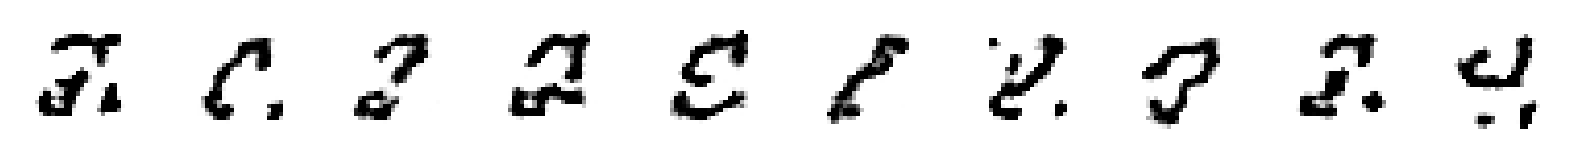

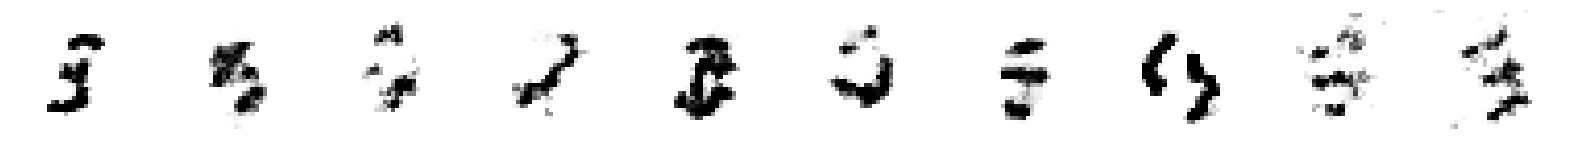

469/469 [==============================] - 1732s 4s/step - loss: 4.5997e-04 - reg: 2.5545e-04 - cdiv: 2.0452e-04 - real: 0.0013 - fake: 0.0015 - val_cdiv: -4.4861 - val_real: -0.0146 - val_fake: -4.5007
Epoch 10/12
469/469 [==============================] - ETA: 0s - loss: -2.0735e-04 - reg: 2.1699e-04 - cdiv: -4.2434e-04 - real: 0.0014 - fake: 9.4840e-04

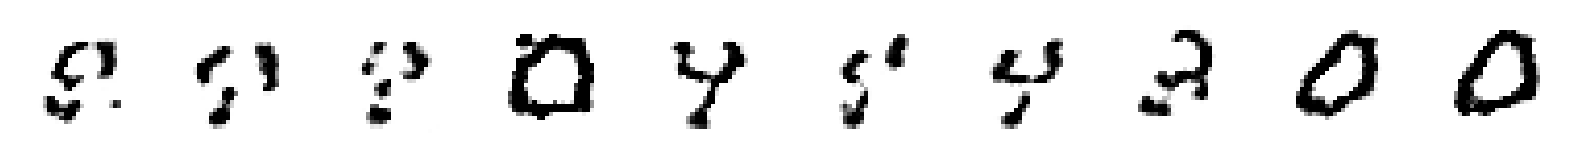

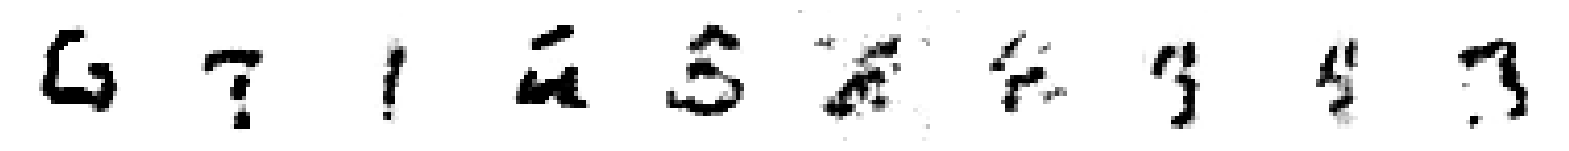

469/469 [==============================] - 1740s 4s/step - loss: -2.0735e-04 - reg: 2.1699e-04 - cdiv: -4.2434e-04 - real: 0.0014 - fake: 9.4840e-04 - val_cdiv: -5.0148 - val_real: 9.4483e-05 - val_fake: -5.0147
Epoch 11/12
  1/469 [..............................] - ETA: 28:16 - loss: -0.0039 - reg: 5.5790e-05 - cdiv: -0.0040 - real: 0.0022 - fake: -0.0018

KeyboardInterrupt: 

In [23]:
history = ebm.fit(
    x_train,
    shuffle=True,
    epochs=12,
    validation_data=x_test,
    callbacks=[
        image_generator_callback,
        save_model_callback,
    ],
)

# generate images

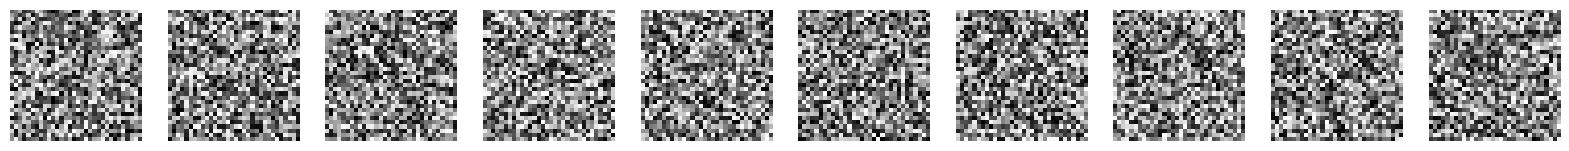

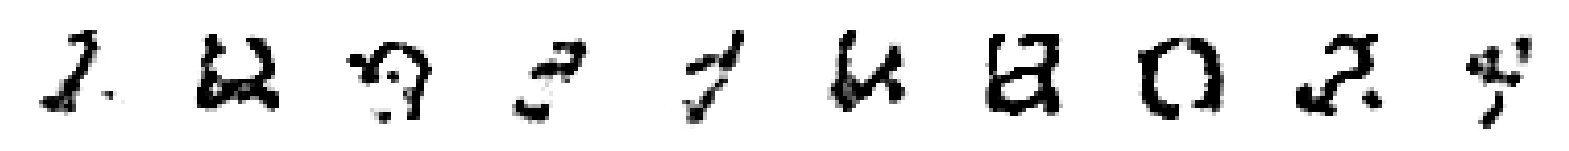

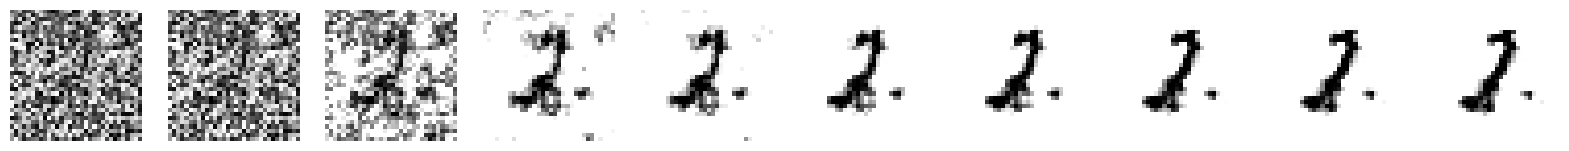

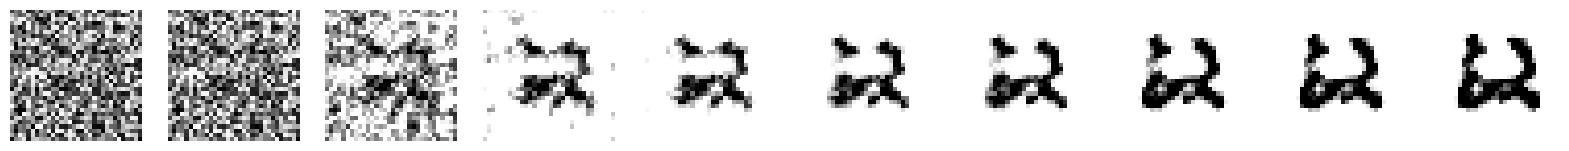

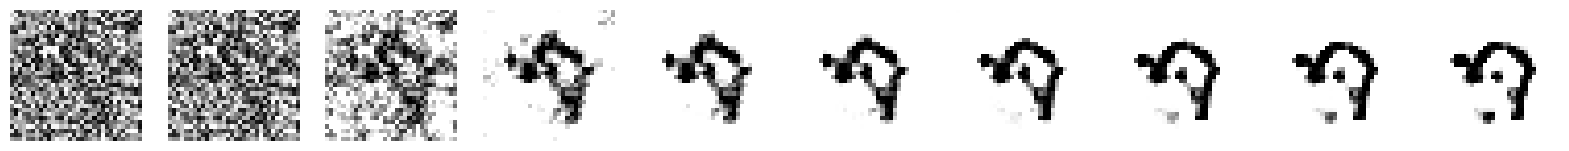

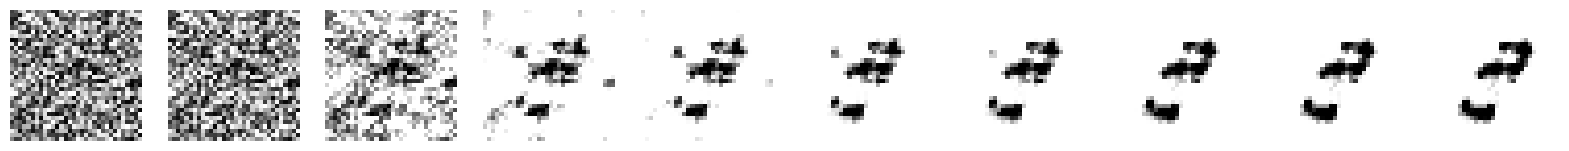

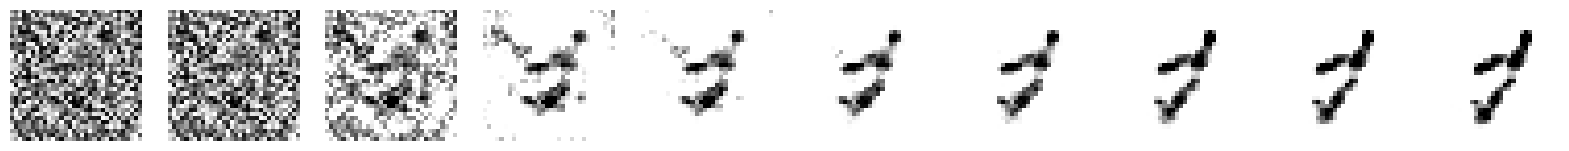

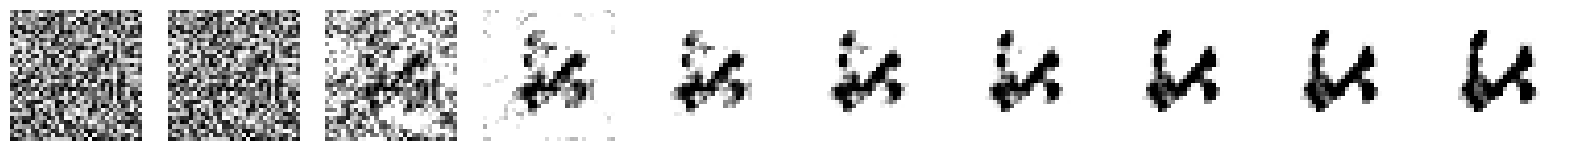

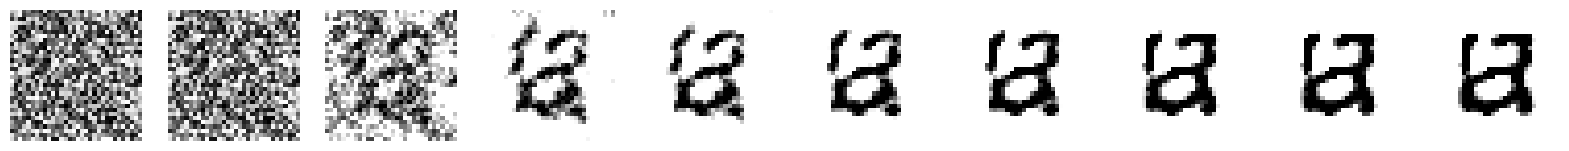

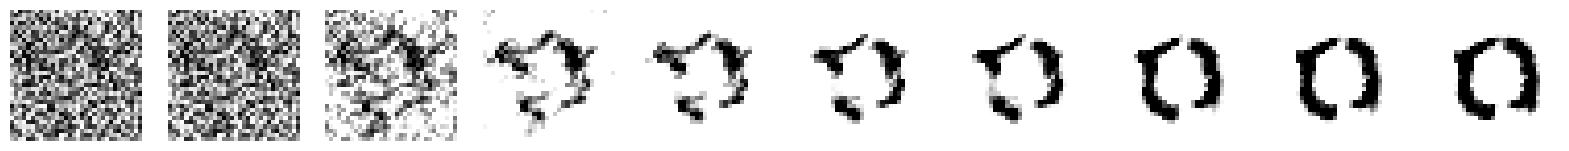

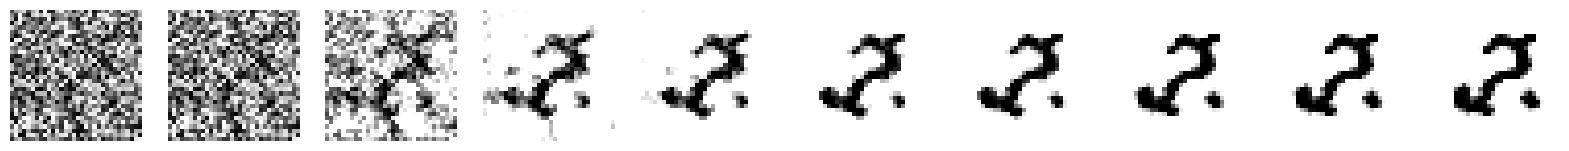

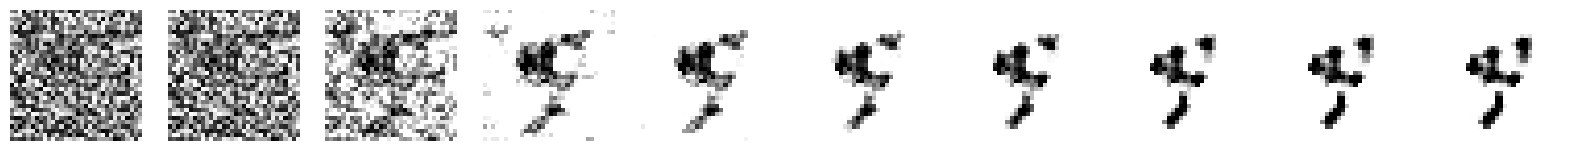

In [34]:
start_imgs = (
    np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
)
display(start_imgs)

gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=700,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

display(gen_img[-1].numpy())

for j in range(10):
    imgs = []
    for i in [0, 1,10,50, 100, 200, 300, 500, 600, 699]:
        imgs.append(gen_img[i].numpy()[j])

    display(np.array(imgs))